# DreamBooth Fine Tuning in Raycluster

In [3]:
!pip install -q ray[default] huggingface_hub

# We can get this address from the workder node of the RayCluster
%env RAY_ADDRESS=gpu-raycluster-head-svc.ray-gpu.svc.cluster.local:6379

env: RAY_ADDRESS=gpu-raycluster-head-svc.ray-gpu.svc.cluster.local:6379


# Check Cluster Resources

The result should be consistent with what we see in the Ray dashboard, under the "overview" tab:

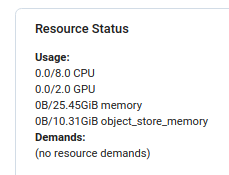

In [7]:
! ray job submit -- python -c "import ray; import json; ray.init(); print(json.dumps(ray.cluster_resources(), indent=2))"

Job submission server address: http://100.64.190.211:8265

-------------------------------------------------------
Job 'raysubmit_2TrzrbCwizGYjxuY' submitted successfully
-------------------------------------------------------

Next steps
  Query the logs of the job:
    ray job logs raysubmit_2TrzrbCwizGYjxuY
  Query the status of the job:
    ray job status raysubmit_2TrzrbCwizGYjxuY
  Request the job to be stopped:
    ray job stop raysubmit_2TrzrbCwizGYjxuY

Tailing logs until the job exits (disable with --no-wait):
2024-01-21 09:48:36,029	INFO worker.py:1405 -- Using address 100.64.190.211:6379 set in the environment variable RAY_ADDRESS
2024-01-21 09:48:36,029	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 100.64.190.211:6379...
2024-01-21 09:48:36,034	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at 100.64.190.211:8265 
{
  "node:__internal_head__": 1.0,
  "node:100.64.190.211": 1.0,
  "object_store_memory": 11070973132.0,
  "memory":

## (Only when necessary) Use `ray job stop` to stop a running job

We have to first "Interrupt the kernel" with the square button in the menlar.

In [ ]:
!ray job stop raysubmit_qEBJ46FmkFFWaNAY

# Step 1: Prepare Data

In [5]:
# Define some environment variables that are used by all

%env ORIG_MODEL_NAME=stabilityai/stable-diffusion-2-1
%env ORIG_MODEL_HASH=5cae40e6a2745ae2b01ad92ae5043f95f23644d6
%env CLASS_NAME=dog
%env UNIQUE_TOKEN=[v]

env: ORIG_MODEL_NAME=stabilityai/stable-diffusion-2-1
env: ORIG_MODEL_HASH=5cae40e6a2745ae2b01ad92ae5043f95f23644d6
env: CLASS_NAME=dog
env: UNIQUE_TOKEN=[v]


## 1.0 Preprare Folders

We should see a `data` folder created under current folder.

In [16]:
%%bash

export DATA_PREFIX="$HOME/efs/src/jark-demo/05_dreambooth_finetuning/data" # EFS is mounted on $HOME/efs
export ORIG_MODEL_DIR="$DATA_PREFIX/model-orig"
export ORIG_MODEL_PATH="$ORIG_MODEL_DIR/models--${ORIG_MODEL_NAME/\//--}/snapshots/$ORIG_MODEL_HASH"
export TUNED_MODEL_DIR="$DATA_PREFIX/model-tuned"
export IMAGES_REG_DIR="$DATA_PREFIX/images-reg"
export IMAGES_OWN_DIR="$DATA_PREFIX/images-own"
export IMAGES_NEW_DIR="$DATA_PREFIX/images-new"

mkdir -p $ORIG_MODEL_DIR $TUNED_MODEL_DIR $IMAGES_REG_DIR $IMAGES_OWN_DIR $IMAGES_NEW_DIR

echo "ORIG_MODEL_DIR=$ORIG_MODEL_DIR"
echo "IMAGES_OWN_DIR=$IMAGES_OWN_DIR"
echo "ORIG_MODEL_PATH=$ORIG_MODEL_PATH"
echo "IMAGES_REG_DIR=$IMAGES_REG_DIR"
echo "TUNED_MODEL_DIR=$TUNED_MODEL_DIR"
echo "IMAGES_OWN_DIR=$IMAGES_OWN_DIR"
echo "IMAGES_NEW_DIR=$IMAGES_NEW_DIR"

ORIG_MODEL_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig
IMAGES_OWN_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own
ORIG_MODEL_PATH=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
IMAGES_REG_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg
TUNED_MODEL_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/model-tuned
IMAGES_OWN_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own
IMAGES_NEW_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-new


## 1.1 Download the Pre-trained Stable Diffusion Model

In [ ]:
%env ORIG_MODEL_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig

import os
from huggingface_hub import snapshot_download

snapshot_download(
        repo_id=os.environ.get('ORIG_MODEL_NAME'),
        revision=os.environ.get('ORIG_MODEL_HASH'), 
        cache_dir=os.environ.get('ORIG_MODEL_DIR')
    )

## 1.2 Download the Input Subjet Data

In this case, we choose the [diffusers/dog-example](https://huggingface.co/datasets/diffusers/dog-example), which contains 5 photos of a particular dog that we'll call "[v] dog".

In [8]:
%env IMAGES_OWN_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own

from huggingface_hub import snapshot_download
import os
import sys

local_dir = os.environ.get('IMAGES_OWN_DIR')

os.makedirs(local_dir, exist_ok=True)

snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)


env: IMAGES_OWN_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

'/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own'

## 1.3 Run Stable Diffusion Inference: on Ray Cluster

Note that we need to set envrionment variables ORIG_MODEL_PATH and IMAGES_REG_DIR based on the location on the Ray cluster instead of the Jupyter notebook. The user is `ray` instead of `jovyan`.

In [9]:
%env PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
%env ORIG_MODEL_PATH=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
%env IMAGES_REG_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg

!ray job submit -- python  ${PROJECT_ROOT}/dreambooth/generate.py \
--model_dir=$ORIG_MODEL_PATH \
--output_dir=$IMAGES_REG_DIR \
--prompts="photo of a $CLASS_NAME" \
--num_samples_per_prompt=200 \
--use_ray_data

env: PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
env: ORIG_MODEL_PATH=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
env: IMAGES_REG_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg
Job submission server address: http://100.64.190.211:8265

-------------------------------------------------------
Job 'raysubmit_4LUuidgHF7DaGY6s' submitted successfully
-------------------------------------------------------

Next steps
  Query the logs of the job:
    ray job logs raysubmit_4LUuidgHF7DaGY6s
  Query the status of the job:
    ray job status raysubmit_4LUuidgHF7DaGY6s
  Request the job to be stopped:
    ray job stop raysubmit_4LUuidgHF7DaGY6s

Tailing logs until the job exits (disable with --no-wait):
[2024-01-21 09:50:04,382] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-01-21 

# Step 2: DreamBooth Training on GPUs

In [10]:
%env PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
%env ORIG_MODEL_PATH=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
%env TUNED_MODEL_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-tuned
%env IMAGES_OWN_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own
%env IMAGES_REG_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg
%env NUM_WORKERS=2

! ray job submit -- python ${PROJECT_ROOT}/dreambooth/train.py \
    --model_dir=$ORIG_MODEL_PATH \
    --output_dir=$TUNED_MODEL_DIR \
    --instance_images_dir=$IMAGES_OWN_DIR \
    --instance_prompt="photo of a $UNIQUE_TOKEN $CLASS_NAME" \
    --class_images_dir=$IMAGES_REG_DIR \
    --class_prompt="photo of a $CLASS_NAME" \
    --train_batch_size=2 \
    --lr=5e-6 \
    --num_epochs=4 \
    --max_train_steps=200 \
    --num_workers $NUM_WORKERS

env: PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
env: ORIG_MODEL_PATH=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
env: TUNED_MODEL_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-tuned
env: IMAGES_OWN_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own
env: IMAGES_REG_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg
env: NUM_WORKERS=2
Job submission server address: http://100.64.190.211:8265

-------------------------------------------------------
Job 'raysubmit_AdA9PcXdJzcriWNJ' submitted successfully
-------------------------------------------------------

Next steps
  Query the logs of the job:
    ray job logs raysubmit_AdA9PcXdJzcriWNJ
  Query the status of the job:
    ray job status raysubmit_AdA9PcXdJzcriWNJ
  Request the job to be stopped:
    ray job stop raysubmit_AdA9PcXdJ

# Step 3: Interference on the Tuned Model

In [17]:
%env PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
%env TUNED_MODEL_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-tuned
%env IMAGES_NEW_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-new
! ray job submit -- python ${PROJECT_ROOT}/dreambooth/generate.py \
    --model_dir=$TUNED_MODEL_DIR \
    --output_dir=$IMAGES_NEW_DIR \
    --prompts="photo of a $UNIQUE_TOKEN $CLASS_NAME in a bucket" \
    --num_samples_per_prompt=4 \
    --use_ray_data

env: PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
env: TUNED_MODEL_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-tuned
env: IMAGES_NEW_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-new
Job submission server address: http://100.64.190.211:8265

-------------------------------------------------------
Job 'raysubmit_VMjycQHnXN1drXN6' submitted successfully
-------------------------------------------------------

Next steps
  Query the logs of the job:
    ray job logs raysubmit_VMjycQHnXN1drXN6
  Query the status of the job:
    ray job status raysubmit_VMjycQHnXN1drXN6
  Request the job to be stopped:
    ray job stop raysubmit_VMjycQHnXN1drXN6

Tailing logs until the job exits (disable with --no-wait):
[2024-01-21 10:46:50,825] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-01-21 10:46:55.702460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64

## Check Output Images

In [2]:
!pip install -q matplotlib Pillow

env: IMAGES_NEW_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-new


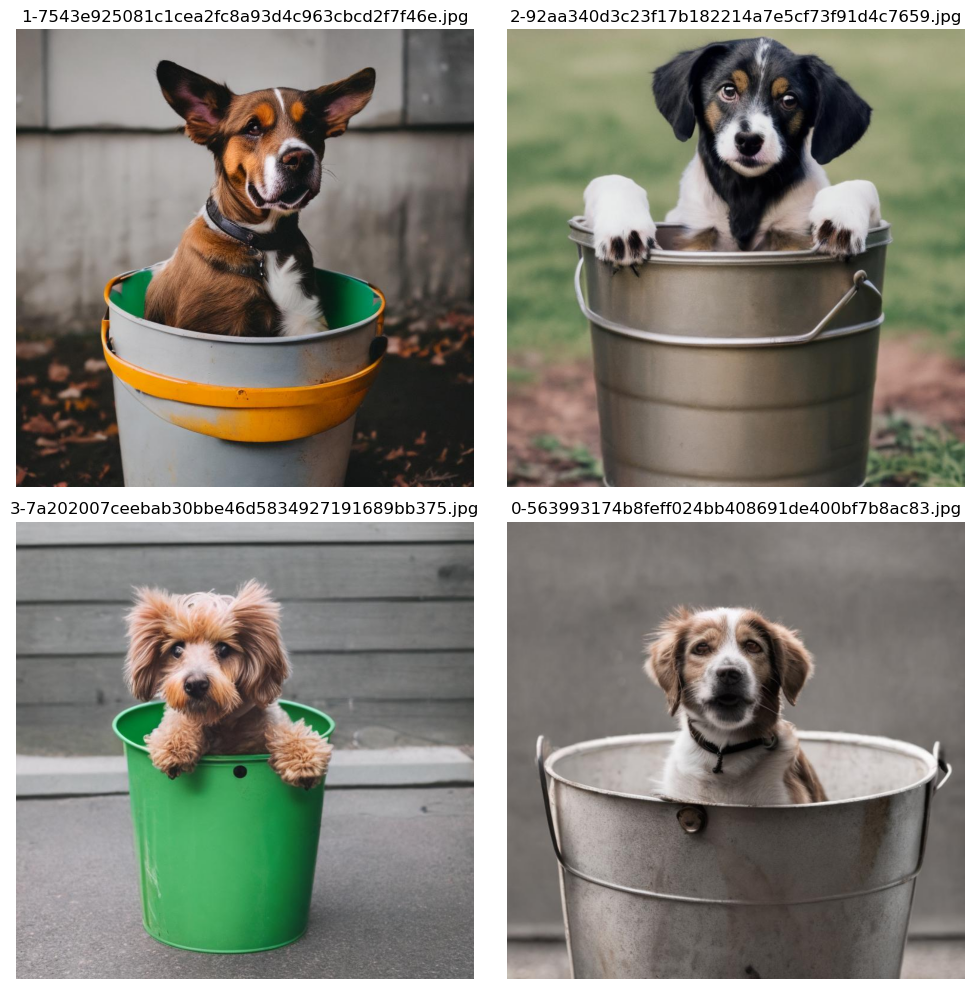

In [19]:
%env IMAGES_NEW_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-new
%matplotlib inline
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the directory directly in the notebook or use an environment variable
images_dir = os.getenv('IMAGES_NEW_DIR', '/path/to/your/images')

# Fetch the first four image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))][:4]

# Display a message if less than four images are found
if len(image_files) < 4:
    print(f"Found {len(image_files)} images, which is less than 4. Displaying what's found.")

# Set up a 2x2 grid for displaying images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# Flatten the 2D grid to a 1D list and remove any surplus axes if images are less than 4
axes_list = [ax for ax in axes.ravel()[:len(image_files)]]

# Display the images
for img_file, ax in zip(image_files, axes_list):
    img_path = os.path.join(images_dir, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide the axis
    ax.set_title(img_file)

# If there are fewer than four images, disable the unused axes
for ax in axes.ravel()[len(image_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# clean the output image folder if necessary
! rm -f ${IMAGES_NEW_DIR}/*.jpg